# Using Multiple "Passes" of the Data Over Time. 

This approach uses the same dataset, but for each galaxy we assigned a datetime value when the final pass occured. Each image was then assigned a capture date of 1 day prior. This simulates 5 nights of obersvations on the same point. 

This can be used to demonstrate how DataRobot makes time-based features from multiple images. 


**Observations for ObjID: 1237661976547295302** 

In [5]:
import pandas as pd

metadata_primary_df = pd.read_csv('https://storage.googleapis.com/public-artifacts-datarobot/astro_images/metadata%201k%20Sample.csv')
metadata_primary_df[metadata_primary_df.ObjID == 1237661976547295302].iloc[0]

ObjID                 1237661976547295302
dec                              8.310277
e_bv                             0.023272
ra                             185.215509
specObjID             1830802092340570112
specz_redshift                   0.072579
specz_redshift_err               0.000017
final_pass_date       2024-02-01 23:01:26
Name: 476, dtype: object

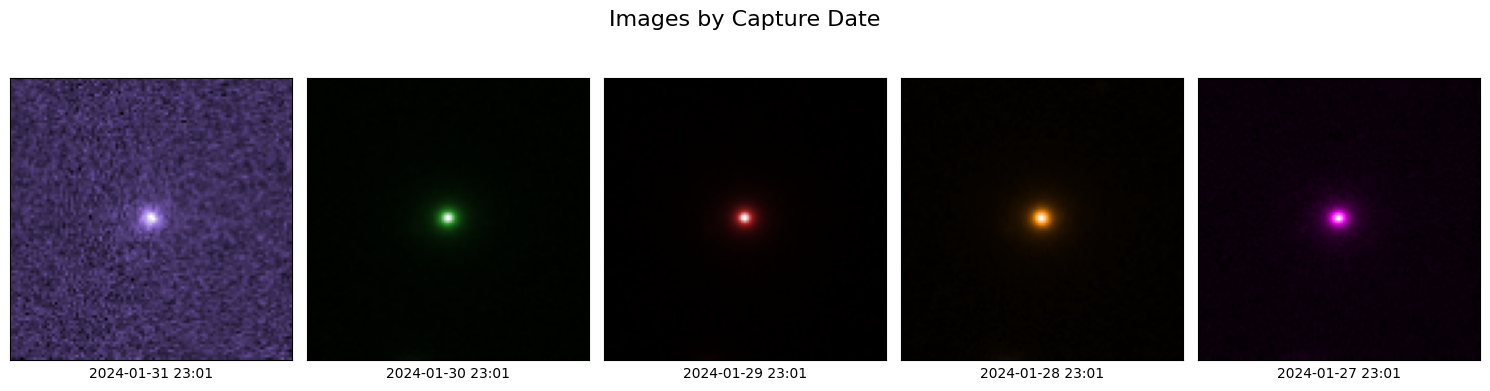

In [7]:
images_secondary_df = pd.read_csv('https://storage.googleapis.com/public-artifacts-datarobot/astro_images/images%201k%20sample.csv')

example_object = images_secondary_df[images_secondary_df.ObjID == 1237661976547295302]

import pandas as pd
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from PIL import Image

def decode_base64_to_image(base64_string):
    # Remove potential base64 header if present
    if ',' in base64_string:
        base64_string = base64_string.split(',')[1]
    
    # Decode base64 to bytes
    image_bytes = base64.b64decode(base64_string)
    
    # Convert bytes to PIL Image
    image = Image.open(BytesIO(image_bytes))
    return image

# Assuming you have a DataFrame named 'df' with columns 'image_data' and 'capture_date'
# Create figure and subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle('Images by Capture Date', fontsize=16)

# Loop through the first 5 rows of the DataFrame
for idx, (ax, (_, row)) in enumerate(zip(axes, example_object.iterrows())):
    # Decode and display image
    img = decode_base64_to_image(row['image_data'])
    ax.imshow(img)
    
    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Format the capture date for the caption
    caption = pd.to_datetime(row['capture_date']).strftime('%Y-%m-%d %H:%M')
    
    # Add caption below the image
    ax.set_xlabel(caption, fontsize=10, labelpad=5)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## DataRobot Project Set-up

To set up this project, we will upload both datasets. The metadata will be used as the primary dataset while the images will be the secondary dataset. The primary dataset has a datetime feature "final_pass_date". This is referred to as the "prediction point" images and other features will be joined into that dataset by looking back a certain time period prior to this point. This is configured in the dataset relationships. 

In [8]:
import datarobot as dr

c = dr.Client(config_path="/Users/luke.shulman/.config/datarobot/drconfig.yml")

primary_dataset = dr.Dataset.create_from_url(
    "https://storage.googleapis.com/public-artifacts-datarobot/astro_images/metadata%201k%20Sample.csv"
)
secondary_dataset = dr.Dataset.create_from_url(
    "https://storage.googleapis.com/public-artifacts-datarobot/astro_images/images%201k%20sample.csv"
)


The following code defines the connection between the primary dataset and the secondary dataset. Configured in the UI, the relationship view will look like this:

![rela](https://storage.googleapis.com/public-artifacts-datarobot/astro_images/fdrealtionshop.png)

In [14]:
def clean_name(name):
    """
    Replace all non-alphanumeric characters in a string with underscores.
    
    Args:
        name (str): The input string to clean
        
    Returns:
        str: The cleaned string with non-alphanumeric chars replaced by _
    """
    return ''.join(char if char.isalnum() else '_' for char in str(name))

identfier_name = clean_name(secondary_dataset.name)
if len(identfier_name) > 20:
    identfier_name = identfier_name[0:20] #names have to be limited to 20 characters
dataset_definition = dr.DatasetDefinition(
    identifier=f"{identfier_name}",
    catalog_id=secondary_dataset.id,
    catalog_version_id=secondary_dataset.version_id,
    # primary_temporal_key="capture_date"
)
relationship = dr.Relationship(
        dataset2_identifier=f"{identfier_name}",
        dataset1_keys=["ObjID"], # this is the primary key in the primary dataset
        dataset2_keys=["ObjID"], # this is the foreign key in the secondary dataset
        feature_derivation_window_start=-30, # pull images taken 30 days prior the last pass
        feature_derivation_window_end=-1,
        feature_derivation_window_time_unit="DAY",
        prediction_point_rounding=1,
        prediction_point_rounding_time_unit="MINUTE",
    )
configuration = dr.RelationshipsConfiguration.create(
        dataset_definitions=[dataset_definition],
        relationships=[relationship],
    )

In [ ]:
project = dr.Project.create_from_dataset(
    primary_dataset.id, project_name="Time Based MultiImage Project 50k"
)

featurelist = project.create_featurelist(
    "remove redshift derivations",
    features=["ra", "dec", "e_bv"],
)

project.set_target(
    target="specz_redshift",
    featurelist_id=featurelist.id,
    feature_engineering_prediction_point="final_pass_date",
    relationships_configuration_id=configuration.id,
    max_wait=3600,
)


Project(Set Based MultiImage Project 50k)

## Previewing the Derived Features

With this project set-up, DataRobot derives features not just from an image but also derives time based features from the metadata associated with each pass.

So for example the feature below `final_pass_date (days from images_1k_sample_csv[capture_date]) (1 week avg)` is a feature calculated by averaging the distance between the capture date of the image and the final pass data on the primary dataset. 

DataRobot Summarizes these in feature lineage charts:

![lineage](https://storage.googleapis.com/public-artifacts-datarobot/astro_images/FeatureLineage.png)


In [ ]:
#project = dr.Project.get("6789b7e8ae8af784d6f8bd8d") # use your project id if rerunning.

top_model = project.get_models()[0]
feat = project.get_features()

features = pd.DataFrame([f.__dict__ for f in feat])
features


,id,project_id,name,feature_type,importance,low_information,unique_count,na_count,date_format,min,...,median,std_dev,time_series_eligible,time_series_eligibility_reason,time_step,time_unit,target_leakage,feature_lineage_id,key_summary,multilabel_insights_key
0,0,6789b7e8ae8af784d6f8bd8d,ObjID,Numeric,-0.005374,False,800,0,None,1237648702970593536,...,1237662236410315008,6059825628714.305664,False,notADate,None,None,FALSE,None,None,None
1,1,6789b7e8ae8af784d6f8bd8d,dec,Numeric,-0.008981,False,800,0,None,-11,...,21.95,18.72,False,notADate,None,None,FALSE,None,None,None
2,2,6789b7e8ae8af784d6f8bd8d,e_bv,Numeric,-0.004079,False,800,0,None,0.00602,...,0.028,0.021,False,notADate,None,None,FALSE,None,None,None
3,7,6789b7e8ae8af784d6f8bd8d,final_pass_date,Date,-0.006310,False,798,0,%Y-%m-%d %H:%M:%S,2024-02-01T00:00:51,...,2024-02-01T11:39:54,0.29 days,False,nonUnique,None,None,FALSE,None,None,None
4,3,6789b7e8ae8af784d6f8bd8d,ra,Numeric,-0.009140,False,800,0,None,0.38,...,185.27,59.82,False,notADate,None,None,FALSE,None,None,None
5,4,6789b7e8ae8af784d6f8bd8d,specObjID,Numeric,-0.008096,False,800,0,None,301779410460108800,...,1632644252527781888,831216251617901696,False,notADate,None,None,FALSE,None,None,None
6,5,6789b7e8ae8af784d6f8bd8d,specz_redshift,Numeric,1.000000,False,800,0,None,0.0028,...,0.104,0.051,False,notADate,None,None,SKIPPED_DETECTION,None,None,None
7,6,6789b7e8ae8af784d6f8bd8d,specz_redshift_err,Numeric,0.252804,False,800,0,None,0.000004,...,0.000019,0.000012,False,notADate,None,None,FALSE,None,None,None
8,13,6789b7e8ae8af784d6f8bd8d,final_pass_date (Hour of Day),Categorical,-0.020212,False,24,0,None,None,...,None,None,False,notADate,None,None,FALSE,None,None,None
9,8,6789b7e8ae8af784d6f8bd8d,final_pass_date (days from images_1k_sample_cs...,Numeric,-0.007606,False,60,0,None,3.5,...,3.5,0.0002,False,notADate,None,None,FALSE,6789b854809e9cc7658a71b3,None,None


### Caveats

So while the time-derived feature derivation would be a good fit for the use case, it does seem that DataRobot will only take the latest image from the secondary dataset `images_1k_sample_csv[image_data] (29 days latest)` rather than using all the images together. 

